In [1]:
import numpy as np
from netCDF4 import Dataset
import datetime
import glob
import os
import matplotlib.pyplot as plt
import cartopy
from matplotlib import gridspec
from regrid import regrid
import pandas as pd
import itertools
import cartopy.crs as ccrs
import tqdm
from scipy.stats import linregress
import warnings
warnings.filterwarnings("ignore")

/opt/anaconda3/envs/phd/lib/python3.8/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [2]:
rho_fyi = 916.7
rho_myi = 882
icetype = np.array(Dataset('/Users/carmennab/Dropbox/met_office/data/auxiliary/icetype.nc')['Ice Type'])
icetype[icetype==2] = rho_fyi
icetype[icetype==3] = rho_myi

In [3]:
datapath = '/Users/carmennab/Dropbox/met_office/data/experiments/FOAM_grid/'
ctrl = Dataset(datapath+'rosie_UCL_CTL_NOSIT_ASSIM_r243541_dcarneir.nc')
base = Dataset(datapath+'rosie_UCL_BASELINE_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_r243541_dcarneir.nc')
unc = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA1_NEW_OBERR_r243541_dcarneir.nc')
### alpha
nine = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA09_r243541_dcarneir.nc')
six = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNFOAM_ALPHA06_r243541_dcarneir.nc')
### retracker
larm = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_BRISTOL_SNFOAM_ALPHA1_r243541_dcarneir.nc')
cpom = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_CPOM_SNFOAM_ALPHA1_r243541_dcarneir.nc')
### snow
smlg = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNLG_ALPHA1_r243541_dcarneir.nc')
awi = Dataset(datapath+'rosie_UCL_SIT_ASSIM_CS2_AWI_SNAWI_ALPHA1_r243541_dcarneir.nc')

sits = [ctrl,base,nine,six,larm,cpom,smlg,awi,unc]
names = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']

foam_lats = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lat_cent.npy')
foam_lons = np.load('/Users/carmennab/Dropbox/met_office/data/auxiliary/lon_cent.npy')

### season total

In [4]:
variables = ['sidmassgrowthbot','sidmassgrowthwat','sidmasssi','sidmassmelttop','sidmassmeltbot',
            'sidmassmeltlat','sidmassth']
var_names = ['congelation','frazil growth','snow-ice growth','top melt','bottom melt',
         'lateral melt','total growth']

data = []
for sit, sit_name in zip(sits,names):
    totals = {}
    for name, variable in zip(var_names,variables):
        area = np.array(sit['area'])
        conc = np.array(sit['siconc'])
        rate = np.array(sit[variable])
        
        sivolu = np.array(sit['sivolu'])
        rate[np.isnan(sivolu)] = np.nan # remove any areas where there is no sea ice
        
        dens = icetype.copy()
        dens[np.isnan(dens)&~np.isnan(rate)] = rho_fyi # if icetype unknown, use fyi density
        mass = rate * (area * conc) * 86400 # convert from rate per second to total mass per day
        vol = mass / dens
        vol_m = np.nansum(vol) # add up grid cells to get total pan-arctic volume
        totals[name] = vol_m * 1e-13 # convert m^3 to 10^4 km^3 
    data.append(totals)     
    
df = pd.DataFrame(data,columns=var_names)
df

,congelation,frazil growth,snow-ice growth,top melt,bottom melt,lateral melt,total growth
0,1.819390,0.681908,0.058934,-0.412379,-0.899332,-0.216359,1.029585
1,2.854148,0.765454,0.054671,-0.411245,-1.146552,-0.230212,1.872123
2,2.952589,0.761358,0.054773,-0.411291,-1.124215,-0.229984,1.989011
3,3.258587,0.749600,0.054915,-0.411243,-1.070937,-0.229061,2.337435
4,2.905392,0.768700,0.055040,-0.411235,-1.134645,-0.230408,1.938550
5,2.799839,0.780224,0.054574,-0.411139,-1.180585,-0.230823,1.797868
6,2.797732,0.778605,0.054467,-0.411194,-1.194023,-0.230076,1.781293
7,2.769589,0.775344,0.054938,-0.411325,-1.189883,-0.230432,1.753970
8,2.488983,0.520935,0.061013,-0.385329,-1.111351,-0.203667,1.367263


### season total relative to BASE

In [5]:
totals = []
for c,d in enumerate(data):
    if c == 1: pass
    else:
        diffs = {}
        for var_name in var_names:
            diffs[var_name] = d[var_name] - data[1][var_name]
        totals.append(diffs)

df_base = pd.DataFrame(totals,columns=var_names)
df_base

,congelation,frazil growth,snow-ice growth,top melt,bottom melt,lateral melt,total growth
0,-1.034758,-0.083546,0.004262,-0.001135,0.247220,0.013853,-0.842538
1,0.098441,-0.004097,0.000102,-0.000046,0.022337,0.000229,0.116888
2,0.404439,-0.015854,0.000244,0.000001,0.075615,0.001152,0.465313
3,0.051243,0.003245,0.000369,0.000010,0.011907,-0.000196,0.066427
4,-0.054309,0.014769,-0.000098,0.000106,-0.034033,-0.000611,-0.074255
5,-0.056416,0.013151,-0.000205,0.000051,-0.047471,0.000137,-0.090829
6,-0.084559,0.009890,0.000267,-0.000081,-0.043331,-0.000220,-0.118152
7,-0.365165,-0.244519,0.006342,0.025916,0.035201,0.026546,-0.504859


### plot figure

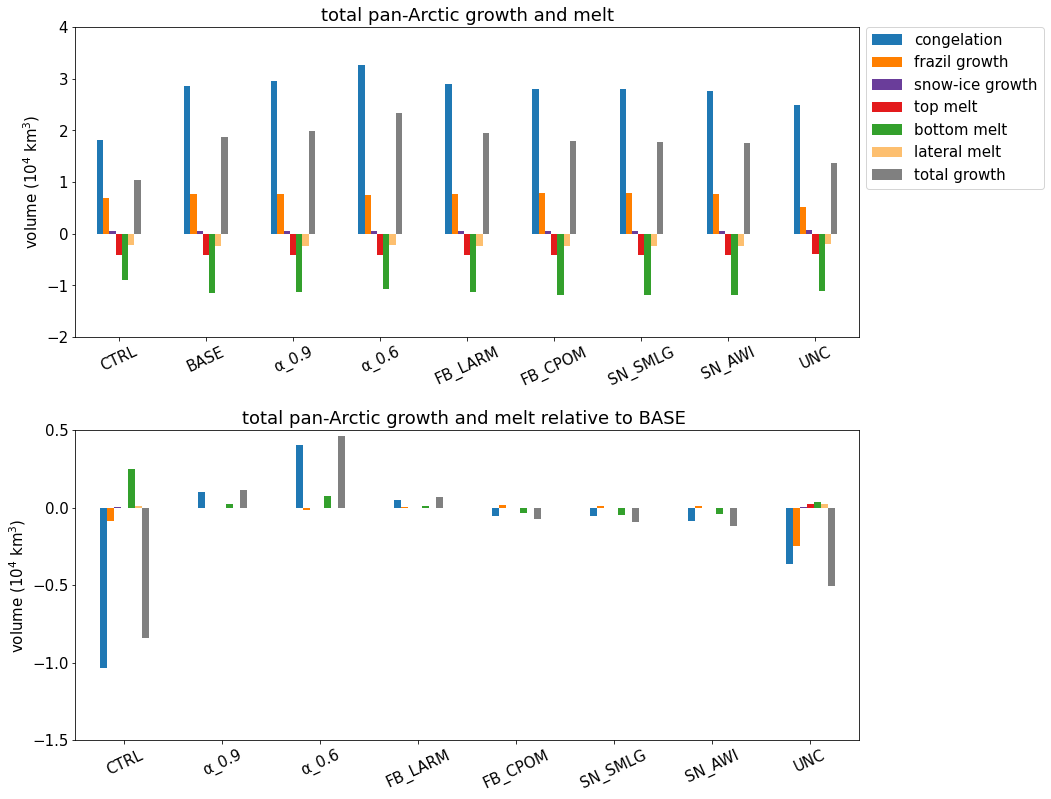

In [7]:
fig,axes = plt.subplots(figsize=(15,11.5),nrows=2, ncols=1)

colors = ['#1f78b4','#ff7f00','#6a3d9a','#e31a1c','#33a02c','#fdbf6f','grey']

names = ['CTRL','BASE','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']
ax = df.plot.bar(ax=axes[0],color=colors)
ax.set_xticklabels(names,rotation=25)
ax.set_ylim([-2,4])
ax.set_yticks([-2,-1,0,1,2,3,4])
ax.legend(var_names,bbox_to_anchor = (1, 1.025))
ax.set_title('total pan-Arctic growth and melt')
ax.set_ylabel('volume (10$^{4}$ km$^{3}$)')

names = ['CTRL','\u03B1_0.9', '\u03B1_0.6','FB_LARM','FB_CPOM','SN_SMLG','SN_AWI','UNC']
ax = df_base.plot.bar(ax=axes[1],legend=False,color=colors)
ax.set_xticklabels(names,rotation=25)
ax.set_title('total pan-Arctic growth and melt relative to BASE ')
ax.set_ylabel('volume (10$^{4}$ km$^{3}$)')
ax.set_ylim([-1.5,0.5])
ax.set_yticks([-1.5,-1,-0.5,0,0.5])
plt.rc('font', size=20)
fig.tight_layout()
datapath = '/Users/carmennab/Dropbox/Apps/Overleaf/FOAM sensitivity/main_figs/'
plt.savefig(datapath+'tmc_deconstructed.png',dpi=400, bbox_inches="tight")